In [217]:
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import prince
from sklearn.feature_selection import SelectKBest, chi2 # for chi-squared feature selection
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.naive_bayes import MultinomialNB

In [218]:
train_data = pd.read_csv('training set values.csv')
train_target = pd.read_csv('training set labels.csv')


In [219]:
# Merge data and labels together in one dataframe.
train_data = pd.merge(train_data, train_target, on='id')
del train_target

In [220]:
# Explore data set.

train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [221]:
train_data.head(3)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional


In [222]:
# Check for nulls.

train_data.apply(lambda x: sum(x.isnull()))

id                           0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [223]:
# Deal with the columns containing null values one by one. Start with 'funder'.

train_data.funder.value_counts()

Government Of Tanzania    9084
Danida                    3114
Hesawa                    2202
Rwssp                     1374
World Bank                1349
                          ... 
Lions C                      1
Wahidi                       1
Hamref                       1
Latfu                        1
Noeli Mahobokela             1
Name: funder, Length: 1897, dtype: int64

In [224]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the 
# information contained in the column.

def funder_wrangler(row):  
    '''Keep top 10 values and set the rest to 'other'''

    if row['funder']=='Government Of Tanzania':
        return 'gov'
    elif row['funder']=='Danida':
        return 'danida'
    elif row['funder']=='Hesawa':
        return 'hesawa'
    elif row['funder']=='Rwssp':
        return 'rwssp'
    elif row['funder']=='World Bank':
        return 'world_bank' 
    elif row['funder']=='Kkkt':
        return 'Kkkt'
    elif row['funder']=='World Vision ':
        return 'World_Vision '
    elif row['funder']=='Unicef':
        return 'Unicef'
    elif row['funder']=='Tasaf':
        return 'Tasaf'
    elif row['funder']=='District Council':
        return 'Dis_Council'
    else:
        return 'other'
    
train_data['funder'] = train_data.apply(lambda row: funder_wrangler(row), axis=1)

In [225]:
# Add column named 'status_group_vals' to allow the use of a pivot table to check differences
# between the different funders.

vals_to_replace = {'functional':2, 'functional needs repair':1,
                   'non functional':0}

train_data['status_group_vals']  = train_data.status_group.replace(vals_to_replace)

In [226]:
per = train_data.groupby(['funder','status_group'])['status_group_vals']\
                                                .count() \
                                                .unstack() \
                                                .reset_index() \
                                                 .fillna(0) \
                                            .set_index('funder')
per.head(10)


status_group,functional,functional needs repair,non functional
funder,,,
Dis_Council,378,45,420
Kkkt,723,66,498
Tasaf,493,64,320
Unicef,600,99,358
danida,1713,159,1242
gov,3720,701,4663
hesawa,936,232,1034
other,22346,2745,13122
rwssp,805,109,460


In [227]:
per['total'] = per.sum(axis=1)

per









status_group,functional,functional needs repair,non functional,total
funder,,,,
Dis_Council,378,45,420,843
Kkkt,723,66,498,1287
Tasaf,493,64,320,877
Unicef,600,99,358,1057
danida,1713,159,1242,3114
gov,3720,701,4663,9084
hesawa,936,232,1034,2202
other,22346,2745,13122,38213
rwssp,805,109,460,1374


In [228]:
def percentage_share(df):
    for i in df.columns:
        df[i] = df.apply(lambda row: (row[i]/row['total']*100), axis=1) 
    df.drop('total',inplace=True,axis=1)
    return df

per_df = percentage_share(per) 

per_df

status_group,functional,functional needs repair,non functional
funder,,,
Dis_Council,44.839858,5.338078,49.822064
Kkkt,56.177156,5.128205,38.694639
Tasaf,56.214367,7.297605,36.488027
Unicef,56.764428,9.366131,33.869442
danida,55.009634,5.105973,39.884393
gov,40.951123,7.716865,51.332012
hesawa,42.506812,10.535876,46.957312
other,58.477481,7.183419,34.339099
rwssp,58.588064,7.933042,33.478894


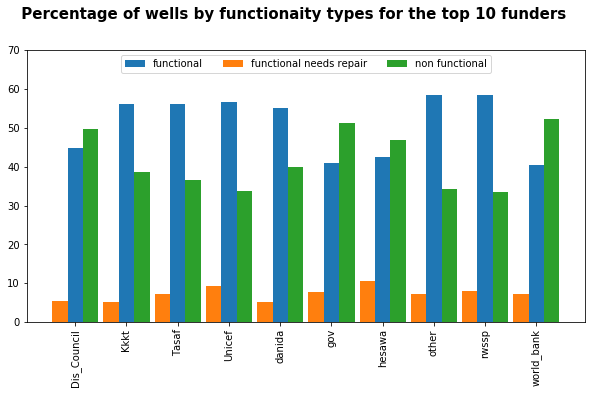

In [229]:
funder = [0,1,2,3,4,5,6,7,8,9]
functional = per_df['functional']
nr_functional = per_df['functional needs repair']
n_functional = per_df['non functional']
header = per_df.columns.values #an array of columns headers

fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(funder)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

ax.set_xticks([0,1,2,3,4,5,6,7,8,9])
ax.set_ylim(0,70)
#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[0]='Dis_Council'
xlab[1]='Kkkt'
xlab[2]='Tasaf'
xlab[3]='Unicef'
xlab[4]='danida'
xlab[5]='gov'
xlab[6] ='hesawa'
xlab[7]='other'
xlab[8]='rwssp'
xlab[9] ='world_bank'


#set the vertical axis tick labels using the list created above
ax.set_xticklabels(xlab)

#for i,v in enumerate(functional):
    #.text(i-.25,v+10,functional[i],fomtsize=8)


for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure
fig.suptitle(' Percentage of wells by functionaity types for the top 10 funders  '\
             ,y=1,fontsize=15,fontweight='bold')
plt.show()

In [230]:
# There are some clear differences here that will hopefully improve the model. The next feature
# to inspect is 'installer'.

train_data.installer.value_counts()

DWE             17402
Government       1825
RWE              1206
Commu            1060
DANIDA           1050
                ...  
ODA                 1
world vision        1
mchina              1
DFID                1
KILANGANI CO        1
Name: installer, Length: 2145, dtype: int64

In [231]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the 
# information contained in the column.

def installer_wrangler(row):
    '''Keep top 7 values and set the rest to 'other'''
    if row['installer']=='DWE':
        return 'dwe'
    elif row['installer']=='Government':
        return 'gov'
    elif row['installer']=='RWE':
        return 'rwe'
    elif row['installer']=='Commu':
        return 'commu'
    elif row['installer']=='DANIDA':
        return 'danida'
    elif row['installer']=='KKKT ':
        return 'KKKT '
    elif row['installer']=='Hesawa':
        return 'Hesawa'
    
    else:
        return 'other'  

train_data['installer'] = train_data.apply(lambda row: installer_wrangler(row), axis=1)

In [232]:
per_inst = train_data.groupby(['installer','status_group'])['status_group_vals']\
                                                .count() \
                                                .unstack() \
                                                .reset_index() \
                                                 .fillna(0) \
                                            .set_index('installer')
per_inst.head(7)

status_group,functional,functional needs repair,non functional
installer,,,
Hesawa,475,17,348
commu,724,32,304
danida,542,83,425
dwe,9433,1622,6347
gov,535,256,1034
other,20246,2170,13601
rwe,304,137,765


In [233]:
per_inst['total'] = per_inst.sum(axis=1)

per_inst

status_group,functional,functional needs repair,non functional,total
installer,,,,
Hesawa,475,17,348,840
commu,724,32,304,1060
danida,542,83,425,1050
dwe,9433,1622,6347,17402
gov,535,256,1034,1825
other,20246,2170,13601,36017
rwe,304,137,765,1206


In [234]:
perinst_df = percentage_share(per_inst) 

perinst_df

status_group,functional,functional needs repair,non functional
installer,,,
Hesawa,56.547619,2.023810,41.428571
commu,68.301887,3.018868,28.679245
danida,51.619048,7.904762,40.476190
dwe,54.206413,9.320768,36.472819
gov,29.315068,14.027397,56.657534
other,56.212344,6.024933,37.762723
rwe,25.207297,11.359867,63.432836


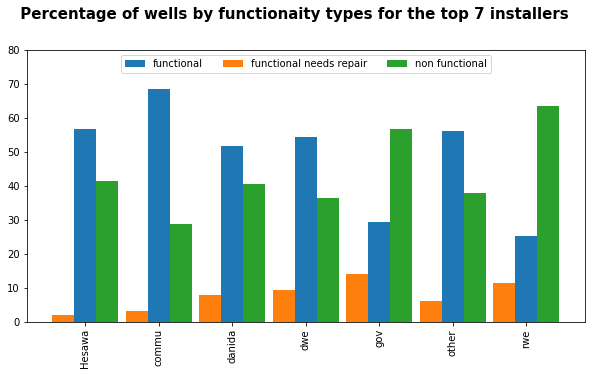

In [235]:
installer = [0,1,2,3,4,5,6]
functional = perinst_df['functional']
nr_functional = perinst_df['functional needs repair']
n_functional = perinst_df['non functional']
header = perinst_df.columns.values #an array of columns headers

fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(installer)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

ax.set_xticks([0,1,2,3,4,5,6])
ax.set_ylim(0,80)
#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[0]='Hesawa'
xlab[1]='commu'
xlab[2]='danida'
xlab[3]='dwe'
xlab[4]='gov'
xlab[5]='other'
xlab[6] ='rwe'



#set the vertical axis tick labels using the list created above
ax.set_xticklabels(xlab)

#for i,v in enumerate(functional):
    #.text(i-.25,v+10,functional[i],fomtsize=8)


for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure
fig.suptitle(' Percentage of wells by functionaity types for the top 7 installers  '\
             ,y=1,fontsize=15,fontweight='bold')
plt.show()

In [236]:
# As was the case with 'funder' there are some clear differences here that will hopefully
# improve the model. The next feature to inspect is 'subvillage'.

print(train_data.subvillage.value_counts())

Madukani       508
Shuleni        506
Majengo        502
Kati           373
Mtakuja        262
              ... 
Kumutukula       1
Nyamaraga        1
Mwabugulula      1
Mwanhinje        1
Migwatani        1
Name: subvillage, Length: 19287, dtype: int64


In [237]:
print('Number of villages: ', len(train_data.subvillage.value_counts()))

Number of villages:  19287


In [238]:
# 19287 unique values! The largest values don't dominate as was the case with installer and
# funder. It's probably not worth creating dummy variables for the top 5. I'll drop this one but
# feel free to experiment here.

train_data.drop('subvillage',inplace = True, axis=1)

In [239]:
# Let's investigate the next column containg null data: 'public_meeting'.

train_data.public_meeting.value_counts()

True     51011
False     5055
Name: public_meeting, dtype: int64

In [240]:
# We only have two values here: true and false. This one can stay but we'll have to replace 
# the unknown data with a string value.

train_data.public_meeting = train_data.public_meeting.fillna('Unknown')

In [241]:
train_data.public_meeting

0           True
1        Unknown
2           True
3           True
4           True
          ...   
59395       True
59396       True
59397       True
59398       True
59399       True
Name: public_meeting, Length: 59400, dtype: object

In [242]:

train_data.scheme_management.value_counts()


VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64

In [243]:
# Create a function to reduce the amount of dummy columns needed whilst maintaining the 
# information contained in the column.

def scheme_wrangler(row):
    '''Keep top 8 values and set the rest to 'other'. '''
    if row['scheme_management']=='VWC':
        return 'vwc'
    elif row['scheme_management']=='WUG':
        return 'wug'
    elif row['scheme_management']=='Water authority':
        return 'wtr_auth'
    elif row['scheme_management']=='WUA':
        return 'wua'
    elif row['scheme_management']=='Water Board':
        return 'wtr_brd'
    elif row['scheme_management']=='Parastatal':
        return 'Parastatal'
    elif row['scheme_management']=='Private operator':
        return 'pri_opr'
    elif row['scheme_management']=='Company':
        return 'comp'
    else:
        return 'other'

train_data['scheme_management'] = train_data.apply(lambda row: scheme_wrangler(row), axis=1)

In [244]:
per_sch_mgmt = train_data.groupby(['scheme_management','status_group'])['status_group_vals']\
                                                .count() \
                                                .unstack() \
                                                .reset_index() \
                                                 .fillna(0) \
                                            .set_index('scheme_management')
per_sch_mgmt.head(8)

status_group,functional,functional needs repair,non functional
scheme_management,,,
Parastatal,966,202,512
comp,534,37,490
other,2398,251,2164
pri_opr,729,23,311
vwc,18960,2334,15499
wtr_auth,1618,448,1087
wtr_brd,2053,111,584
wua,1995,239,649


In [245]:
per_sch_mgmt['total'] = per_sch_mgmt.sum(axis=1)

per_sch_mgmt

status_group,functional,functional needs repair,non functional,total
scheme_management,,,,
Parastatal,966,202,512,1680
comp,534,37,490,1061
other,2398,251,2164,4813
pri_opr,729,23,311,1063
vwc,18960,2334,15499,36793
wtr_auth,1618,448,1087,3153
wtr_brd,2053,111,584,2748
wua,1995,239,649,2883
wug,3006,672,1528,5206


In [246]:
#calculating the percentage
per_sch_mgmt_df = percentage_share(per_sch_mgmt) 

per_sch_mgmt_df

status_group,functional,functional needs repair,non functional
scheme_management,,,
Parastatal,57.500000,12.023810,30.476190
comp,50.329877,3.487276,46.182846
other,49.823395,5.215043,44.961562
pri_opr,68.579492,2.163688,29.256820
vwc,51.531541,6.343598,42.124861
wtr_auth,51.316207,14.208690,34.475103
wtr_brd,74.708879,4.039301,21.251820
wua,69.198751,8.289976,22.511273
wug,57.741068,12.908183,29.350749


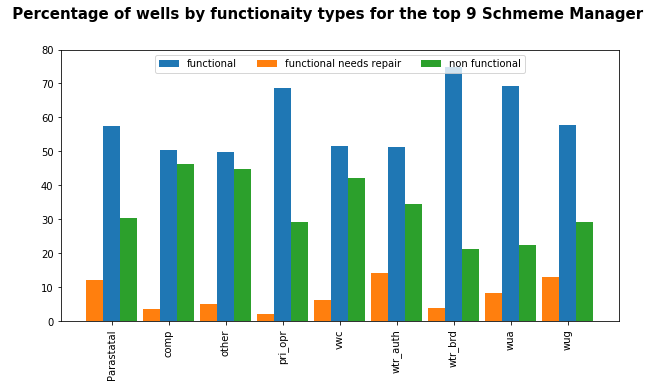

In [247]:
scheme_management = [0,1,2,3,4,5,6,7,8]
functional = per_sch_mgmt_df['functional']
nr_functional = per_sch_mgmt_df['functional needs repair']
n_functional = per_sch_mgmt_df['non functional']
header = per_sch_mgmt_df.columns.values #an array of columns headers

fig = plt.figure()
ax = plt.subplot()

#Grouped bar chart
ind = np.arange(len(scheme_management)) #no of x ticks;
width = 0.3 #width of the bar


#ax.bar(position of the bar wrt the x-ticks, data, width of bar, label)
ax.bar(ind , functional, width,label='functional')
ax.bar(ind- width , nr_functional, width,label='functional needs repair')
ax.bar(ind + width , n_functional, width,label='non functional')
ax.legend(loc=9,ncol=3)

ax.set_xticks([0,1,2,3,4,5,6,7,8])
ax.set_ylim(0,80)
#create a list of  variable names to use as labels for ticks in hor axis
xlab=[item.get_text() for item in ax.get_xticklabels()] # list with empty strings. list length determined my the ticks seen in the plots
# replace empty strings at even list indexes by variable names in the same order as they are present in the dataframe column names
xlab[0]='Parastatal'
xlab[1]='comp'
xlab[2]='other'
xlab[3]='pri_opr'
xlab[4]='vwc'
xlab[5]='wtr_auth'
xlab[6] ='wtr_brd'
xlab[7] ='wua'
xlab[8] ='wug'



#set the vertical axis tick labels using the list created above
ax.set_xticklabels(xlab)

#for i,v in enumerate(functional):
    #.text(i-.25,v+10,functional[i],fomtsize=8)


for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#Set the figure size so that all four panel graphs are clearly visible
fig.set_size_inches(10,5)   
#Set a title for the figure
fig.suptitle(' Percentage of wells by functionaity types for the top 9 Schmeme Manager  '\
             ,y=1,fontsize=15,fontweight='bold')
plt.show()

In [248]:
train_data.scheme_name.value_counts()

K                                     682
None                                  644
Borehole                              546
Chalinze wate                         405
M                                     400
                                     ... 
Mtawanya                                1
Oltogomu water scheme                   1
Hasu                                    1
Kakonko/Mbizi gravity water supply      1
BL Ormelili                             1
Name: scheme_name, Length: 2696, dtype: int64

In [249]:
len(train_data.scheme_name.unique())

2697

In [250]:
# Lots of factors and the top 5 or so only represent a fraction of the total values. Probably 
# safe to drop this column.

train_data.drop('scheme_name',inplace = True , axis=1)

In [251]:
# The final column containing nulls is 'permit'.

train_data.permit.value_counts()

True     38852
False    17492
Name: permit, dtype: int64

In [252]:
# We only have two values here: true and false. This one can stay but we'll have to replace 
# the unknown data with a string value.

train_data.permit = train_data.permit.fillna('Unknown')

In [253]:

train_data.apply(lambda x: sum(x.isnull()))

id                       0
amount_tsh               0
date_recorded            0
funder                   0
gps_height               0
installer                0
longitude                0
latitude                 0
wpt_name                 0
num_private              0
basin                    0
region                   0
region_code              0
district_code            0
lga                      0
ward                     0
population               0
public_meeting           0
recorded_by              0
scheme_management        0
permit                   0
construction_year        0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
w

In [254]:
# Excellent! Now there are no nulls in the data set. We can move on to look at columns with 
# string values and modify or remove them as we see fit.

str_cols = train_data.select_dtypes(include = ['object'])
str_cols.apply(lambda x: len(x.unique()))

date_recorded              356
funder                      10
installer                    7
wpt_name                 37400
basin                        9
region                      21
lga                        125
ward                      2092
public_meeting               3
recorded_by                  1
scheme_management            9
permit                       3
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_group                6
quantity                     5
quantity_group               5
source                      10
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
dtype: int64

In [255]:
# 'Date recorded'

train_data.date_recorded.describe()

count          59400
unique           356
top       2011-03-15
freq             572
Name: date_recorded, dtype: object

In [256]:
# Let's first convert the column to type datetime. Then change the column to represent the 
# number of days since the most recently recorded datum we have. The idea being that more 
# recently recorded pumps might be more likely to be functional than non-functional. 

train_data.date_recorded = pd.to_datetime(train_data.date_recorded)
train_data.date_recorded.describe()

count                   59400
unique                    356
top       2011-03-15 00:00:00
freq                      572
first     2002-10-14 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [257]:
# The most recent data is 2013-12-03. Subtract each date from this point to obtain a 
# 'days_since_recorded' column.

train_data.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(train_data.date_recorded)
train_data.columns = ['days_since_recorded' if x=='date_recorded' else x for x in train_data.columns]
train_data.days_since_recorded = train_data.days_since_recorded.astype('timedelta64[D]').astype(int)
train_data.days_since_recorded.describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


count    59400.000000
mean       613.616970
std        334.216374
min          0.000000
25%        297.000000
50%        419.000000
75%        977.000000
max       4068.000000
Name: days_since_recorded, dtype: float64

In [258]:
# There's a wide range of data here hopefully it will help improve the predictive power of our
# models. Next up for inspection is 'wpt_name' (Name of the waterpoint if there is one).

train_data.wpt_name.value_counts()

none                    3563
Shuleni                 1748
Zahanati                 830
Msikitini                535
Kanisani                 323
                        ... 
Kwa Timbela                1
Angelita Mbatia            1
Kwa Trayfory Kamgoba       1
Kwa Mzee Zalali            1
Beater Mpumilo             1
Name: wpt_name, Length: 37400, dtype: int64

In [259]:
# Due to the huge number of factors and the lack of a clear dominating value I'll drop this.
# I may come back and include the top 5 later. Next up is 'basin'.

train_data.drop('wpt_name',inplace = True , axis=1)

In [260]:
train_data.basin.value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

In [261]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 39 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   days_since_recorded    59400 non-null  int64  
 3   funder                 59400 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              59400 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   num_private            59400 non-null  int64  
 9   basin                  59400 non-null  object 
 10  region                 59400 non-null  object 
 11  region_code            59400 non-null  int64  
 12  district_code          59400 non-null  int64  
 13  lga                    59400 non-null  object 
 14  ward                   59400 non-null  object 
 15  po

In [262]:
piv_table = pd.pivot_table(train_data, index=['basin', 'status_group'],
                           values=['status_group_vals'], aggfunc='count')
piv_table

status_group_vals
basin                   status_group                              
Internal                functional                            4482
                        functional needs repair                557
                        non functional                        2746
Lake Nyasa              functional                            3324
                        functional needs repair                250
                        non functional                        1511
Lake Rukwa              functional                            1000
                        functional needs repair                270
                        non functional                        1184
Lake Tanganyika         functional                            3107
                        functional needs repair                742
                        non functional                        2583
Lake Victoria           functional                            5100
                        functional needs repair                989
                        non functional                        4159
Pangani                 functional                            5372
                        functional needs repair                477
                        non functional                        3091
Rufiji                  functional                            5068
                        functional needs repair                437
                        non functional                        2471
Ruvuma / Southern Coast functional                            1670
                        functional needs repair                326
                        non functional                        2497
Wami / Ruvu             functional                            3136
                        functional needs repair                269
                        non functional                        2582

In [263]:
# Most basins have have more functional than non-functional pumps. Lake Rukwa
# and Ruvuma don't. All the values are over 2000 so this looks like a good feature to keep.
# Region will be considered next.

In [264]:

train_data.region.value_counts()

Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64

In [265]:
# Both basin, lga, ward and region contain geographical information so there is a risk of them being
# highly correlated with each other. I'll drop then for now.
# They could be be worth including though, so I may come back to them.
train_data.drop(['region', 'lga', 'ward'],inplace = True, axis=1)

In [266]:
train_data.recorded_by.value_counts().describe()

count        1.0
mean     59400.0
std          NaN
min      59400.0
25%      59400.0
50%      59400.0
75%      59400.0
max      59400.0
Name: recorded_by, dtype: float64

In [267]:
# All data points have the same value so this offers no information that would help build our
# model.
train_data.drop('recorded_by',inplace = True, axis=1)

In [268]:
# extraction_type, extraction_type_group and extraction_type_class appear to contain very similar
# data. I'll drop the first two and keep the last one.

train_data.drop(['extraction_type', 'extraction_type_group'],inplace = True, axis=1)

In [269]:
train_data.management.value_counts()

vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64

In [270]:
# This appears to be almost identical to 'scheme_management'. I'll drop it.

train_data.drop('management',inplace = True, axis=1)

In [271]:
train_data.management_group.value_counts()

user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int64

In [272]:
train_data.scheme_management.unique()

array(['vwc', 'other', 'pri_opr', 'wug', 'wtr_brd', 'wua', 'wtr_auth',
       'comp', 'Parastatal'], dtype=object)

In [273]:
# Appears to offer no new info and is likely to overlap with 'scheme_management'.

train_data.drop('management_group',inplace = True, axis=1)

In [274]:
train_data.payment.value_counts()

never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64

In [275]:
train_data.payment_type.value_counts()

never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64

In [276]:
# Payment and payment_type contain identical data. Remove one and keep the other.

train_data.drop('payment',inplace = True, axis=1)

In [277]:

train_data.water_quality.value_counts()

soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64

In [278]:
train_data.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

In [279]:
# Water_quality and quality_group contain identical data. Remove one and keep the other.

train_data.drop('water_quality',inplace = True, axis = 1)

In [280]:
train_data.quantity.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64

In [281]:
train_data.quantity_group.value_counts()

enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64

In [282]:
# Quantity and quantity_group contain identical data. Remove one and keep the other.

train_data.drop('quantity_group',inplace = True,axis = 1)

In [283]:
train_data.source.value_counts()

spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64

In [284]:
train_data.source_class.value_counts()

groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64

In [285]:
train_data.source_type.value_counts()

spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64

In [286]:
# Source and source_type contain very similar information. Remove one and keep the other.

train_data.drop('source',inplace = True,axis =  1)

In [287]:
# gps_height, longitude, latitude, region_code and district_code are all geographic info which
# is unlikely to add any predictive power to the model given that there are other variables
# containing geographic data. 'num_private' hasn't been given a discription on Driven Data,
# it appears to be superflous. We expect id to not contain any useful information so that gets
# dropped too.

train_data.drop(['gps_height','region_code', 'district_code',
             'num_private', 'id'], inplace = True,axis=1)

In [288]:
train_data.describe()


,amount_tsh,days_since_recorded,longitude,latitude,population,construction_year,status_group_vals
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000
mean,317.650385,613.616970,34.077427,-5.706033e+00,179.909983,1300.652475,1.158838
std,2997.574558,334.216374,6.567432,2.946019e+00,471.482176,951.620547,0.949794
min,0.000000,0.000000,0.000000,-1.164944e+01,0.000000,0.000000,0.000000
25%,0.000000,297.000000,33.090347,-8.540621e+00,0.000000,0.000000,0.000000
50%,0.000000,419.000000,34.908743,-5.021597e+00,25.000000,1986.000000,2.000000
75%,20.000000,977.000000,37.178387,-3.326156e+00,215.000000,2004.000000,2.000000
max,350000.000000,4068.000000,40.345193,-2.000000e-08,30500.000000,2013.000000,2.000000


In [289]:
train_data.apply(lambda x: len(x.unique()))

amount_tsh                  98
days_since_recorded        356
funder                      10
installer                    7
longitude                57516
latitude                 57517
basin                        9
population                1049
public_meeting               3
scheme_management            9
permit                       3
construction_year           55
extraction_type_class        7
payment_type                 7
quality_group                6
quantity                     5
source_type                  7
source_class                 3
waterpoint_type              7
waterpoint_type_group        6
status_group                 3
status_group_vals            3
dtype: int64

In [290]:
train_data.construction_year.value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [291]:
# Turn construction_year into a categorical column containing the following values: '60s', '70s',
# '80s', '90s, '00s', '10s', 'unknown'.

def construction_wrangler(row):
    if row['construction_year'] >= 1960 and row['construction_year'] < 1970:
        return '60s'
    elif row['construction_year'] >= 1970 and row['construction_year'] < 1980:
        return '70s'
    elif row['construction_year'] >= 1980 and row['construction_year'] < 1990:
        return '80s'
    elif row['construction_year'] >= 1990 and row['construction_year'] < 2000:
        return '90s'
    elif row['construction_year'] >= 2000 and row['construction_year'] < 2010:
        return '00s'
    elif row['construction_year'] >= 2010:
        return '10s'
    else:
        return 'unknown'
    
train_data['construction_year'] = train_data.apply(lambda row: construction_wrangler(row), axis=1)

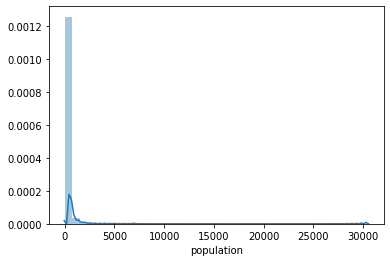

In [292]:
sns.distplot(train_data.population, bins = 40)
plt.show()

In [293]:
train_data.construction_year.value_counts()

unknown    20709
00s        15330
90s         7678
80s         5578
10s         5161
70s         4406
60s          538
Name: construction_year, dtype: int64

In [294]:
# This plot measures the amount of water available at the pump. It looks a lot like the 
# population graph which makes sense. 

train_data.population.describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

In [295]:
train_data.amount_tsh.describe()

count     59400.000000
mean        317.650385
std        2997.574558
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max      350000.000000
Name: amount_tsh, dtype: float64

In [296]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import descartes
from shapely.geometry import Point , Polygon

import seaborn as sns
import hdbscan 


In [297]:
shp = gpd.GeoDataFrame.from_file('tza/tza_map.shp')

In [298]:
indexNames = train_data[ train_data['longitude'] == 0.00 ].index
train_data.drop(indexNames , inplace=True)

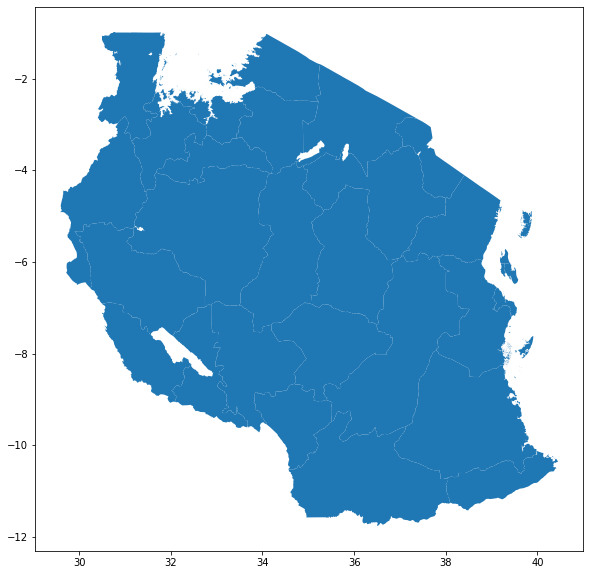

In [299]:
fig,ax = plt.subplots(figsize =(10,10))
shp.plot(ax = ax)

In [300]:
crs = {'init' : 'epsg:4326'}
train_data.head()

,amount_tsh,days_since_recorded,funder,installer,longitude,latitude,basin,population,public_meeting,scheme_management,...,extraction_type_class,payment_type,quality_group,quantity,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,status_group_vals
0,6000.0,995,other,other,34.938093,-9.856322,Lake Nyasa,109,True,vwc,...,gravity,annually,good,enough,spring,groundwater,communal standpipe,communal standpipe,functional,2
1,0.0,272,other,other,34.698766,-2.147466,Lake Victoria,280,Unknown,other,...,gravity,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2
2,25.0,281,other,other,37.460664,-3.821329,Pangani,250,True,vwc,...,gravity,per bucket,good,enough,dam,surface,communal standpipe multiple,communal standpipe,functional,2
3,0.0,309,Unicef,other,38.486161,-11.155298,Ruvuma / Southern Coast,58,True,vwc,...,submersible,never pay,good,dry,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0
4,0.0,874,other,other,31.130847,-1.825359,Lake Victoria,0,True,other,...,gravity,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,2


In [301]:
lat_data = train_data[['longitude','latitude']]
lat_data.shape

(57588, 2)

In [302]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=1500, gen_min_span_tree=True)

In [303]:
clusterer.fit(lat_data)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=1500, min_samples=None, p=None,
        prediction_data=False)

In [304]:
clusterer.labels_.max()

8

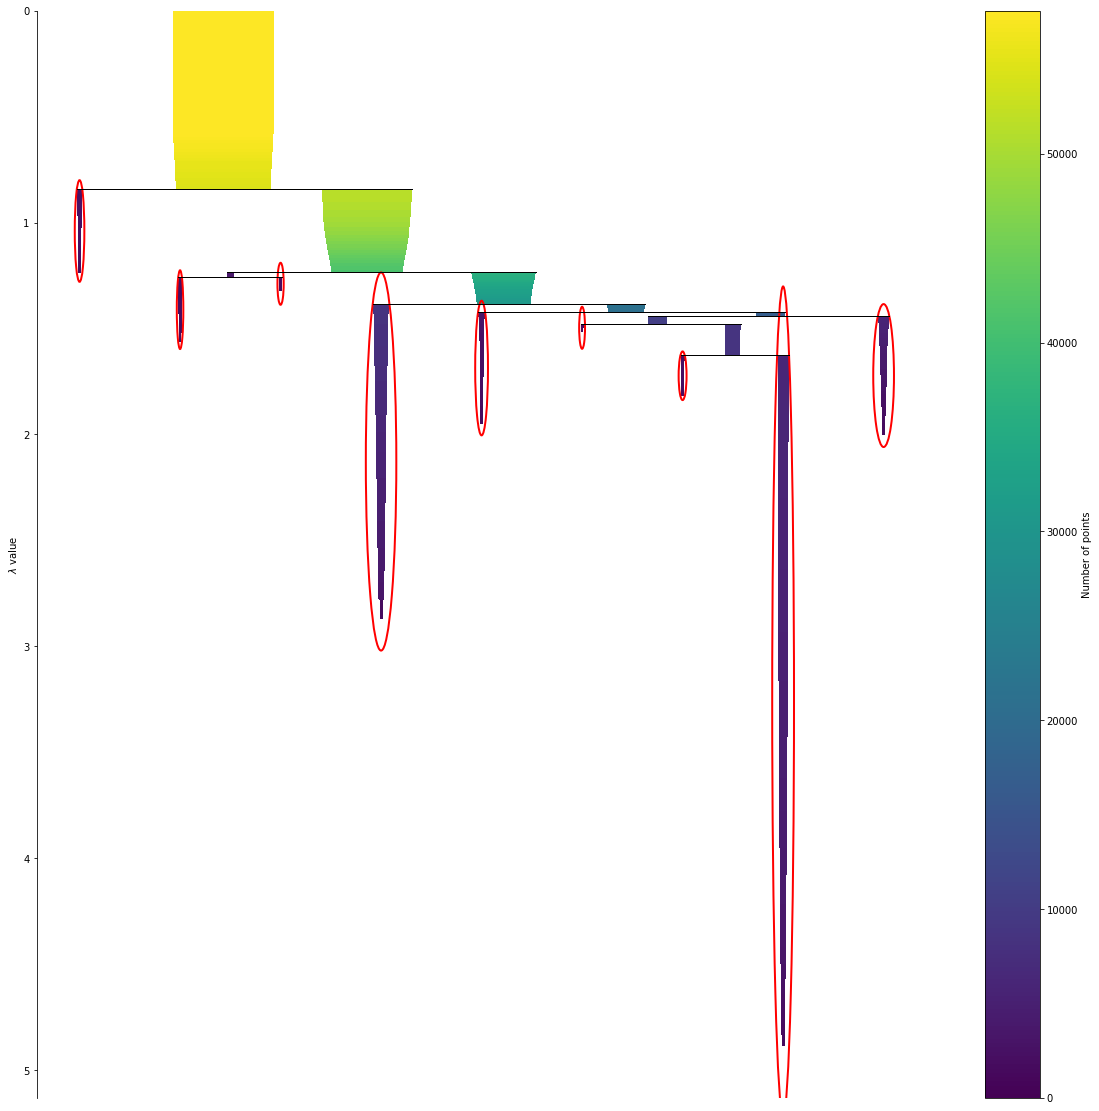

In [305]:
fig = plt.figure()
clusterer.condensed_tree_.plot(select_clusters=True,
                               selection_palette=sns.color_palette('deep', 8))
fig.set_size_inches(20, 20, forward=True)
plt.show()

In [306]:
train_data['geo_cluster'] = clusterer.labels_

In [307]:
np.unique(clusterer.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [308]:
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l== -1:
            cols.append('green')
        elif l== 0:
            cols.append('yellow')
        elif l==1:
            cols.append('red')
        elif l==2:
            cols.append('blue')
        elif l==3:
            cols.append('orange')
        elif l==4:
            cols.append('black')
        elif l==5:
            cols.append('grey')
        elif l==6:
            cols.append('chocolate')
        elif l==7:
            cols.append('pink')
        elif l==8:
            cols.append('lime')
            

    return cols
# Create the colors list using the function above
cluster_colors=pltcolor(clusterer.labels_)

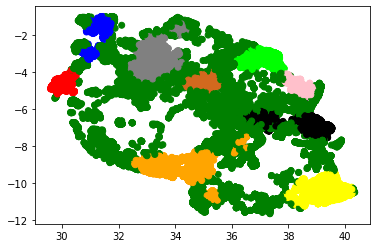

In [309]:
plt.scatter(train_data['longitude'], train_data['latitude'], c=cluster_colors)

In [310]:
train_data['geo_color'] = cluster_colors

In [311]:
np.unique(cluster_colors)

array(['black', 'blue', 'chocolate', 'green', 'grey', 'lime', 'orange',
       'pink', 'red', 'yellow'], dtype='<U9')

In [312]:
geometry = [Point(xy) for xy in zip(train_data['longitude'],train_data['latitude'])]
geometry[:3]

In [313]:
geo_df = gpd.GeoDataFrame(train_data,
                         crs = crs,
                         geometry = geometry)

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


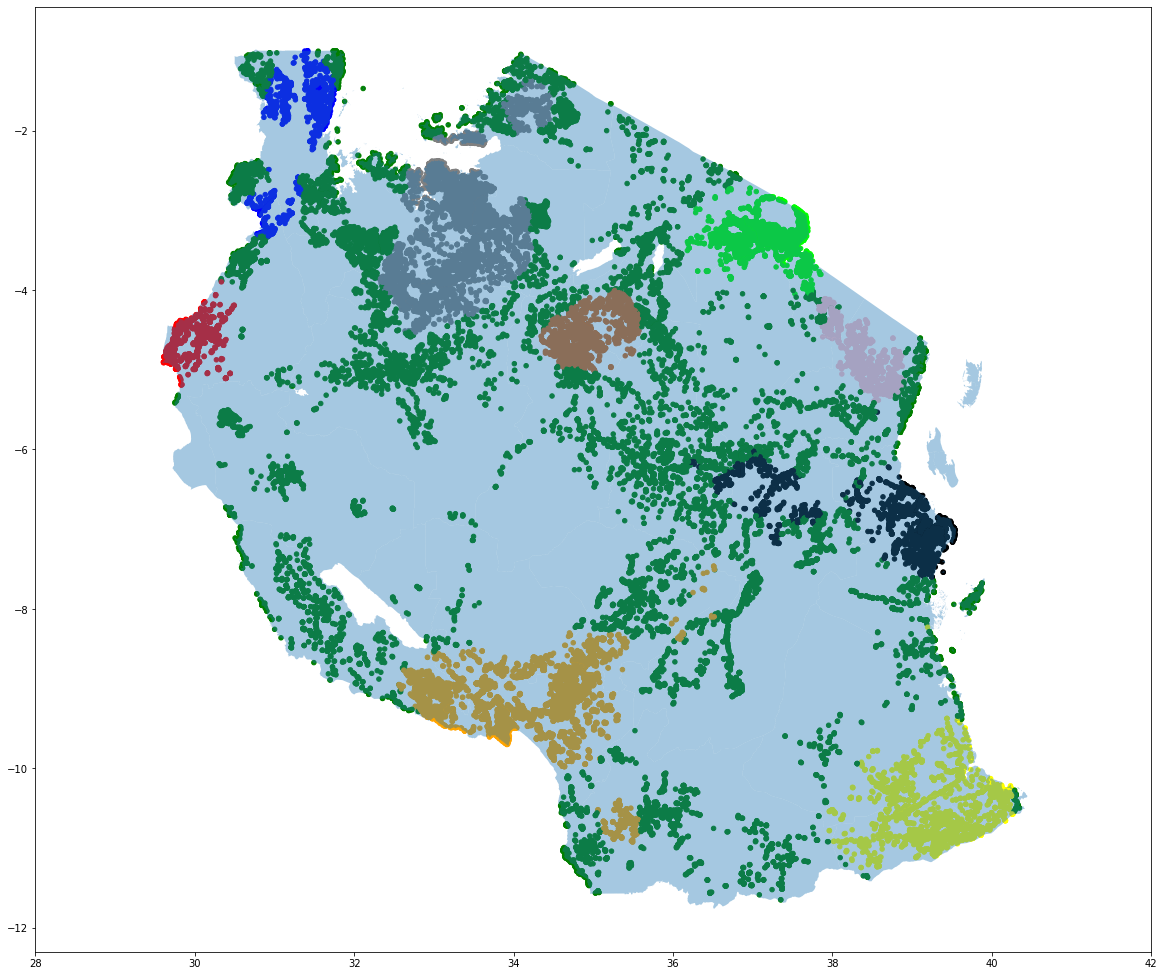

In [314]:
fig,ax = plt.subplots(figsize =(20,20))
ax.set_xlim(28,42)
geo_df.plot(ax=ax,markersize = 20, color = train_data['geo_color'] , marker = 'o')
shp.plot(ax = ax , alpha = 0.4)

In [81]:
test_data = pd.read_csv('test set values.csv')

In [82]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14850 entries, 0 to 14849
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     14850 non-null  int64  
 1   amount_tsh             14850 non-null  float64
 2   date_recorded          14850 non-null  object 
 3   funder                 13981 non-null  object 
 4   gps_height             14850 non-null  int64  
 5   installer              13973 non-null  object 
 6   longitude              14850 non-null  float64
 7   latitude               14850 non-null  float64
 8   wpt_name               14850 non-null  object 
 9   num_private            14850 non-null  int64  
 10  basin                  14850 non-null  object 
 11  subvillage             14751 non-null  object 
 12  region                 14850 non-null  object 
 13  region_code            14850 non-null  int64  
 14  district_code          14850 non-null  int64  
 15  lg

In [83]:
test_data.drop(['gps_height', 'longitude', 'latitude', 'region_code', 'district_code',
                  'num_private', 'id', 'payment', 'management_group', 'management', 
                  'extraction_type', 'extraction_type_group', 'recorded_by','region', 'lga',
                  'ward', 'wpt_name', 'scheme_name', 'subvillage', 'quantity_group',
                 'quality_group', 'source'],inplace = True,axis=1)



In [84]:
test_data.date_recorded = pd.to_datetime(test_data.date_recorded)
test_data.date_recorded.describe()

count                   14850
unique                    331
top       2013-02-03 00:00:00
freq                      138
first     2001-03-26 00:00:00
last      2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [85]:
# The most recent data is 2013-12-03. Subtract each date from this point to obtain a 
# 'days_since_recorded' column.

test_data.date_recorded = pd.datetime(2013, 12, 3) - pd.to_datetime(test_data.date_recorded)
test_data.columns = ['days_since_recorded' if x=='date_recorded' else x for x in test_data.columns]
test_data.days_since_recorded = test_data.days_since_recorded.astype('timedelta64[D]').astype(int)
test_data.days_since_recorded.describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.


count    14850.000000
mean       618.477172
std        338.603783
min          0.000000
25%        298.000000
50%        422.000000
75%        978.000000
max       4635.000000
Name: days_since_recorded, dtype: float64

In [86]:
test_data.permit = test_data.permit.fillna('Unknown')
test_data.public_meeting = test_data.public_meeting.fillna('Unknown')

In [87]:
test_data['scheme_management'] = test_data.apply(lambda row: scheme_wrangler(row), axis=1)

In [88]:
test_data['construction_year'] = test_data.apply(lambda row: construction_wrangler(row), axis=1)
test_data['installer'] = test_data.apply(lambda row: installer_wrangler(row), axis=1)
test_data['funder'] = test_data.apply(lambda row: funder_wrangler(row), axis=1)

In [315]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57588 entries, 0 to 59399
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   amount_tsh             57588 non-null  float64 
 1   days_since_recorded    57588 non-null  int64   
 2   funder                 57588 non-null  object  
 3   installer              57588 non-null  object  
 4   longitude              57588 non-null  float64 
 5   latitude               57588 non-null  float64 
 6   basin                  57588 non-null  object  
 7   population             57588 non-null  int64   
 8   public_meeting         57588 non-null  object  
 9   scheme_management      57588 non-null  object  
 10  permit                 57588 non-null  object  
 11  construction_year      57588 non-null  object  
 12  extraction_type_class  57588 non-null  object  
 13  payment_type           57588 non-null  object  
 14  quality_group          57588 non-null 

In [316]:
train_data.drop(['status_group','latitude','longitude','geo_color'],inplace = True, axis=1)

In [327]:
train_data.drop('geometry',inplace = True, axis=1)

In [328]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57588 entries, 0 to 59399
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             57588 non-null  float64
 1   days_since_recorded    57588 non-null  int64  
 2   funder                 57588 non-null  object 
 3   installer              57588 non-null  object 
 4   basin                  57588 non-null  object 
 5   population             57588 non-null  int64  
 6   public_meeting         57588 non-null  object 
 7   scheme_management      57588 non-null  object 
 8   permit                 57588 non-null  object 
 9   construction_year      57588 non-null  object 
 10  extraction_type_class  57588 non-null  object 
 11  payment_type           57588 non-null  object 
 12  quality_group          57588 non-null  object 
 13  quantity               57588 non-null  object 
 14  source_type            57588 non-null  object 
 15  so

In [168]:
test_data.shape

NameError: name 'test_data' is not defined

In [191]:
train_data.shape

(57588, 20)

In [318]:
train_data.columns

Index(['amount_tsh', 'days_since_recorded', 'funder', 'installer', 'basin',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'payment_type',
       'quality_group', 'quantity', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group_vals',
       'geo_cluster', 'geometry'],
      dtype='object')

In [81]:
cat_df = train_data.select_dtypes(include='object')



cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   funder                 59400 non-null  object
 1   installer              59400 non-null  object
 2   basin                  59400 non-null  object
 3   public_meeting         59400 non-null  object
 4   scheme_management      59400 non-null  object
 5   permit                 59400 non-null  object
 6   construction_year      59400 non-null  object
 7   extraction_type_class  59400 non-null  object
 8   payment_type           59400 non-null  object
 9   quality_group          59400 non-null  object
 10  quantity               59400 non-null  object
 11  source_type            59400 non-null  object
 12  source_class           59400 non-null  object
 13  waterpoint_type        59400 non-null  object
 14  waterpoint_type_group  59400 non-null  object
 15  status_group       

In [82]:
cat_df.drop(['funder', 'installer', 'scheme_management', 'construction_year', 'quantity','waterpoint_type'],inplace = True,axis=1)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [83]:
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   basin                  59400 non-null  object
 1   public_meeting         59400 non-null  object
 2   permit                 59400 non-null  object
 3   extraction_type_class  59400 non-null  object
 4   payment_type           59400 non-null  object
 5   quality_group          59400 non-null  object
 6   source_type            59400 non-null  object
 7   source_class           59400 non-null  object
 8   waterpoint_type_group  59400 non-null  object
 9   status_group           59400 non-null  object
dtypes: object(10)
memory usage: 5.0+ MB


In [84]:
cat2_df = train_data[['funder', 'installer', 'scheme_management', 'construction_year', 'quantity','waterpoint_type','status_group']]

In [85]:
cat2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   funder             59400 non-null  object
 1   installer          59400 non-null  object
 2   scheme_management  59400 non-null  object
 3   construction_year  59400 non-null  object
 4   quantity           59400 non-null  object
 5   waterpoint_type    59400 non-null  object
 6   status_group       59400 non-null  object
dtypes: object(7)
memory usage: 3.6+ MB


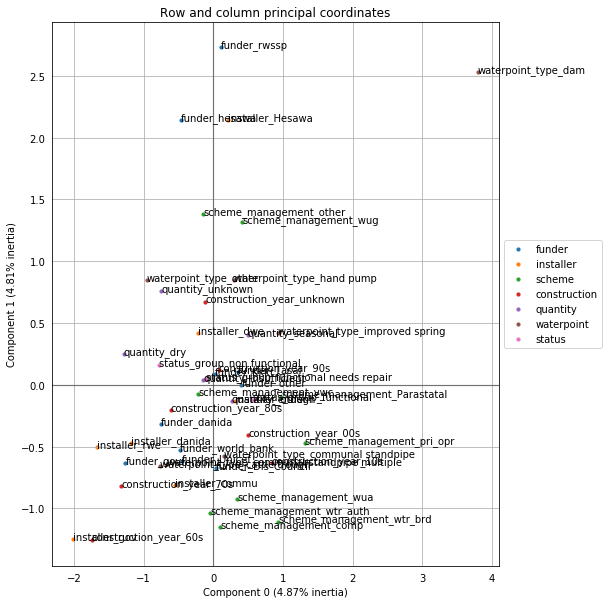

In [87]:
mca = prince.MCA(
        n_components=2,
        n_iter=3,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=42
        )
churn_mca = mca.fit(cat2_df)

ax = churn_mca.plot_coordinates(
        X=cat2_df,
        ax=None,
        figsize=(8, 10),
        show_row_points=False,
        row_points_size=0,
        show_row_labels=False,
        show_column_points=True,
        column_points_size=10,
        show_column_labels=True,
        legend_n_cols=1
               ).legend(loc='center left', bbox_to_anchor=(1, 0.5))

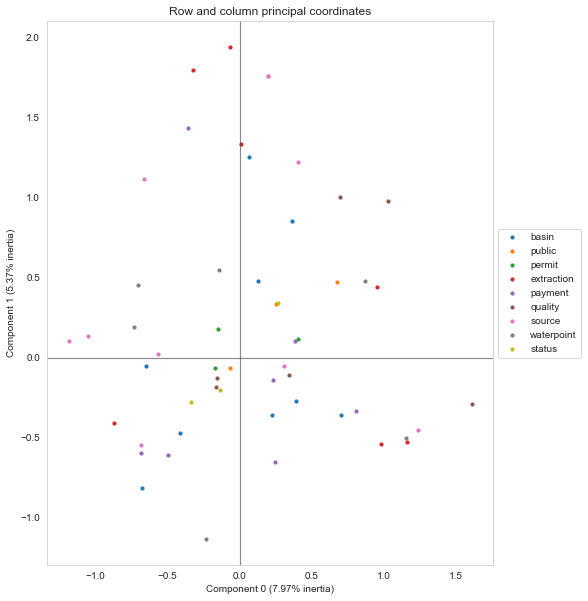

In [171]:
mca = prince.MCA(
        n_components=2,
        n_iter=3,
        copy=True,
        check_input=True,
        engine='auto',
        random_state=42
        )
churn_mca = mca.fit(cat_df)

ax = churn_mca.plot_coordinates(
        X=cat_df,
        ax=None,
        figsize=(8, 10),
        show_row_points=False,
        row_points_size=0,
        show_row_labels=False,
        show_column_points=True,
        column_points_size=10,
        show_column_labels=False,
        legend_n_cols=1
               ).legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [113]:
churn2 = pd.get_dummies(cat_df, drop_first=False)

In [114]:
print(churn2.shape)

(59400, 54)


In [115]:
print("The data set contains: {} rows and {} columns".format(churn2.shape[0], churn2.shape[1]))
print("Features after get_dummies:\n", list(churn2.columns))

The data set contains: 59400 rows and 54 columns
Features after get_dummies:
 ['basin_Internal', 'basin_Lake Nyasa', 'basin_Lake Rukwa', 'basin_Lake Tanganyika', 'basin_Lake Victoria', 'basin_Pangani', 'basin_Rufiji', 'basin_Ruvuma / Southern Coast', 'basin_Wami / Ruvu', 'public_meeting_False', 'public_meeting_True', 'public_meeting_Unknown', 'permit_False', 'permit_True', 'permit_Unknown', 'extraction_type_class_gravity', 'extraction_type_class_handpump', 'extraction_type_class_motorpump', 'extraction_type_class_other', 'extraction_type_class_rope pump', 'extraction_type_class_submersible', 'extraction_type_class_wind-powered', 'payment_type_annually', 'payment_type_monthly', 'payment_type_never pay', 'payment_type_on failure', 'payment_type_other', 'payment_type_per bucket', 'payment_type_unknown', 'quality_group_colored', 'quality_group_fluoride', 'quality_group_good', 'quality_group_milky', 'quality_group_salty', 'quality_group_unknown', 'source_type_borehole', 'source_type_dam', '

In [116]:
y = churn2[['status_group_functional','status_group_functional needs repair', 'status_group_non functional']] # target variable
X = churn2.drop(['status_group_functional','status_group_functional needs repair', 'status_group_non functional'],axis=1) # input categorical features


In [117]:
# categorical feature selection
sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)
# print feature scores
for i in range(len(sf_fit.scores_)):
    print(' %s: %f' % (X.columns[i], sf_fit.scores_[i]))

 basin_Internal: 35.530079
 basin_Lake Nyasa: 253.612197
 basin_Lake Rukwa: 191.795267
 basin_Lake Tanganyika: 208.953087
 basin_Lake Victoria: 131.441654
 basin_Pangani: 135.416944
 basin_Rufiji: 275.321373
 basin_Ruvuma / Southern Coast: 586.991201
 basin_Wami / Ruvu: 101.972423
 public_meeting_False: 261.956384
 public_meeting_True: 44.171404
 public_meeting_Unknown: 77.871905
 permit_False: 48.124954
 permit_True: 21.535402
 permit_Unknown: 34.520204
 extraction_type_class_gravity: 944.183000
 extraction_type_class_handpump: 507.205685
 extraction_type_class_motorpump: 454.509639
 extraction_type_class_other: 4887.351064
 extraction_type_class_rope pump: 23.046671
 extraction_type_class_submersible: 106.720369
 extraction_type_class_wind-powered: 8.185213
 payment_type_annually: 690.811137
 payment_type_monthly: 912.896916
 payment_type_never pay: 969.864077
 payment_type_on failure: 101.724691
 payment_type_other: 40.775107
 payment_type_per bucket: 661.952180
 payment_type_unknow

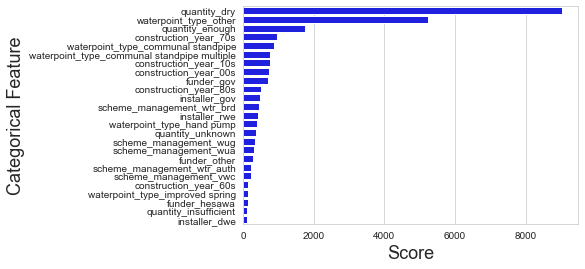

In [128]:
# plot the scores
datset = pd.DataFrame()
datset['feature'] = X.columns[ range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=False)
sns.barplot(datset['scores'][0:25], datset['feature'][0:25], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

In [120]:
churn1 = pd.get_dummies(cat2_df, drop_first=False)

In [122]:
print(churn1.shape)

(59400, 48)


In [123]:
print("The data set contains: {} rows and {} columns".format(churn1.shape[0], churn1.shape[1]))
print("Features after get_dummies:\n", list(churn1.columns))

The data set contains: 59400 rows and 48 columns
Features after get_dummies:
 ['funder_Dis_Council', 'funder_Kkkt', 'funder_Tasaf', 'funder_Unicef', 'funder_danida', 'funder_gov', 'funder_hesawa', 'funder_other', 'funder_rwssp', 'funder_world_bank', 'installer_Hesawa', 'installer_commu', 'installer_danida', 'installer_dwe', 'installer_gov', 'installer_other', 'installer_rwe', 'scheme_management_Parastatal', 'scheme_management_comp', 'scheme_management_other', 'scheme_management_pri_opr', 'scheme_management_vwc', 'scheme_management_wtr_auth', 'scheme_management_wtr_brd', 'scheme_management_wua', 'scheme_management_wug', 'construction_year_00s', 'construction_year_10s', 'construction_year_60s', 'construction_year_70s', 'construction_year_80s', 'construction_year_90s', 'construction_year_unknown', 'quantity_dry', 'quantity_enough', 'quantity_insufficient', 'quantity_seasonal', 'quantity_unknown', 'waterpoint_type_cattle trough', 'waterpoint_type_communal standpipe', 'waterpoint_type_commu

In [124]:
y = churn1[['status_group_functional','status_group_functional needs repair', 'status_group_non functional']] # target variable
X = churn1.drop(['status_group_functional','status_group_functional needs repair', 'status_group_non functional'],axis=1) # input categorical features



In [125]:
# categorical feature selection
sf = SelectKBest(chi2, k='all')
sf_fit = sf.fit(X, y)
# print feature scores
for i in range(len(sf_fit.scores_)):
    print(' %s: %f' % (X.columns[i], sf_fit.scores_[i]))

 funder_Dis_Council: 46.735754
 funder_Kkkt: 8.958172
 funder_Tasaf: 1.443570
 funder_Unicef: 13.285733
 funder_danida: 22.032436
 funder_gov: 694.831216
 funder_hesawa: 130.558801
 funder_other: 288.658764
 funder_rwssp: 14.216822
 funder_world_bank: 116.721629
 installer_Hesawa: 34.531385
 installer_commu: 90.749346
 installer_danida: 3.135005
 installer_dwe: 118.209377
 installer_gov: 482.555852
 installer_other: 104.688615
 installer_rwe: 412.146674
 scheme_management_Parastatal: 83.062192
 scheme_management_comp: 40.577562
 scheme_management_other: 99.258515
 scheme_management_pri_opr: 101.218791
 scheme_management_vwc: 226.590779
 scheme_management_wtr_auth: 227.007774
 scheme_management_wtr_brd: 460.901752
 scheme_management_wua: 311.849334
 scheme_management_wug: 350.742176
 construction_year_00s: 744.848831
 construction_year_10s: 767.116997
 construction_year_60s: 149.610783
 construction_year_70s: 952.646615
 construction_year_80s: 509.414919
 construction_year_90s: 4.794637

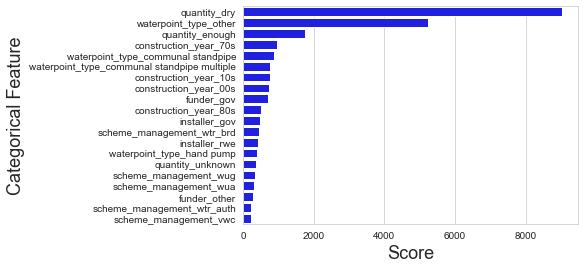

In [127]:
# plot the scores
datset = pd.DataFrame()
datset['feature'] = X.columns[ range(len(sf_fit.scores_))]
datset['scores'] = sf_fit.scores_
datset = datset.sort_values(by='scores', ascending=False)
sns.barplot(datset['scores'][0:20], datset['feature'][0:20], color='blue')
sns.set_style('whitegrid')
plt.ylabel('Categorical Feature', fontsize=18)
plt.xlabel('Score', fontsize=18)
plt.show()

In [330]:

train_data['status_group_vals'].value_counts()

2    31389
0    22268
1     3931
Name: status_group_vals, dtype: int64

In [331]:
data_train, data_test = train_test_split(train_data, test_size=0.25,random_state=1443,stratify=train_data.status_group_vals)

In [332]:
X_train1 = data_train
y_train = data_train['status_group_vals']


X_test1 = data_test
y_test = data_test['status_group_vals']


In [333]:
X_test1.columns

Index(['amount_tsh', 'days_since_recorded', 'funder', 'installer', 'basin',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'payment_type',
       'quality_group', 'quantity', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group_vals',
       'geo_cluster'],
      dtype='object')

In [334]:
X_train = pd.get_dummies(X_train1)
X_train.drop('status_group_vals',inplace=True,axis=1)
X_test = pd.get_dummies(X_test1)
X_test.drop('status_group_vals',inplace=True,axis=1)

In [335]:
gnb = GaussianNB()

In [203]:
clf = MultinomialNB()

In [336]:
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [204]:
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [205]:
y_pred = clf.predict(X_test)

In [206]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.45405292769326944


In [337]:
y_pred = gnb.predict(X_test)

In [338]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6151281516982705


In [339]:
from sklearn.ensemble import RandomForestClassifier

In [340]:
model = RandomForestClassifier(n_estimators=200,max_depth=50, random_state=14400)

In [341]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=14400,
                       verbose=0, warm_start=False)

In [342]:
y_pred = model.predict(X_test)

In [343]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7846079044245329


In [344]:
def pltcolor(lst):
    cols=[]
    for l in lst:
        if l==0:
            cols.append('green')
        elif l==1:
            cols.append('yellow')
        elif l==2:
            cols.append('red')

    return cols
# Create the colors list using the function above
cols_pred=pltcolor(y_pred)
cols_true=pltcolor(y_test)


(0, 12000)

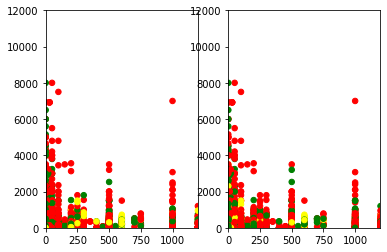

In [345]:
ax1=plt.subplot(1,2,1)
ax1.scatter(X_test1['amount_tsh'],X_test1['population'],c = cols_pred,s=30)
ax1.set_xlim(0,1200)
ax1.set_ylim(0,12000)
ax2=plt.subplot(1,2,2)
ax2.scatter(X_test1['amount_tsh'],X_test1['population'],c = cols_true,s=30)
ax2.set_xlim(0,1200)
ax2.set_ylim(0,12000)


In [346]:
from sklearn.naive_bayes import BernoulliNB

In [347]:
clf1 = BernoulliNB()

In [348]:
clf1.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [349]:
y_pred = clf1.predict(X_test)

In [350]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6483295130930055
